# Test curve fitting

The function `y = sinc(10 * x)` is fitted using a Shallow Neural Network with 61 parameters.
Despite the triviality of the problem, first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.

In [7]:
import os

os.chdir("../content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0
Receiving objects: 100% (53/53), 32.99 KiB | 11.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [8]:
!pip install tensorflow 

# Setup Levenberg-Marquardt
### Install dependencies from GitHub

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MaxAbsScaler

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

In [10]:
df_25 = create_dataframe(grid=5)
df_1000 = create_dataframe(grid=32)

In [11]:
df_25

,X,Y,Z
0,-2.0,-2.0,0.046835
1,-1.0,-2.0,-0.592128
2,0.0,-2.0,-4.759612
3,1.0,-2.0,-2.102351
4,2.0,-2.0,-0.061640
5,-2.0,-1.0,-0.130053
6,-1.0,-1.0,1.855892
7,0.0,-1.0,-0.723906
8,1.0,-1.0,-0.272917
9,2.0,-1.0,0.499636


In [12]:
df_1000

,X,Y,Z
0,-2.000000,-2.0,0.046835
1,-1.870968,-2.0,0.060663
2,-1.741935,-2.0,0.070183
3,-1.612903,-2.0,0.067332
4,-1.483871,-2.0,0.039844
...,...,...,...
1019,1.483871,2.0,0.708371
1020,1.612903,2.0,0.487302
1021,1.741935,2.0,0.325461
1022,1.870968,2.0,0.211038


In [13]:
def split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)  # Randomiza as linhas

    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import levenberg_marquardt as lm
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras import initializers

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
      self.batch_size = batch_size

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      train_dataset = tf.data.Dataset.from_tensor_slices((input, output))
      train_dataset = train_dataset.shuffle(len(input))
      train_dataset = train_dataset.batch(self.batch_size).cache()
      train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (train_dataset, input, output)


    def split_dataset(self, input, output, sup_input, sup_output):

      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, random_state=42)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, random_state=42)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)


    def create_model(self, input_size=2, sumary=False):
      regularizer = regularizers.L2(0.2)
      initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)

      self.model = tf.keras.Sequential([
          tf.keras.layers.Dense(30,
                                activation='tanh',
                                input_shape=(input_size,),
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(16,
                                activation='tanh',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(1,
                                activation='linear',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
)])

      if (sumary == True):
        self.model.summary()

      self.model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          loss=tf.keras.losses.MeanSquaredError())

      self.lm_model = lm.ModelWrapper(
          tf.keras.models.clone_model(self.model))

      self.lm_model.compile(
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
          loss=lm.MeanSquaredError())

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
      sup_pred = self.lm_model.predict(self.sup_input).flatten()

      r2 = r2_score(self.output, pred)
      r2_test = r2_score(self.test_output, test_pred)
      r2_val = r2_score(self.val_output, val_pred)
      r2_vt = r2_score(self.vt_output, vt_pred)
      r2_sup = r2_score(self.sup_output, sup_pred)

      mse = mean_squared_error(self.output, pred)
      mse_test = mean_squared_error(self.test_output, test_pred)
      mse_val = mean_squared_error(self.val_output, val_pred)
      mse_vt = mean_squared_error(self.vt_output, vt_pred)
      mse_sup = mean_squared_error(self.sup_output, sup_pred)

      metrics = {
                      'r2': r2,
                      'r2_sup': r2_sup,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_sup': mse_sup,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics



In [105]:
from keras import saving
from keras import models

class Tester:
  def __init__(self, run_times=500):
    self.run_times = run_times
    self.metrics = []
    self.better_results = {}

  def PrepareTraining(self, model=None):
    trainer = TrainWithSmallDataset()
    input_25, output_25 = split_df(df_25)
    input_1000, output_1000 = split_df(df_1000)
    trainer.split_dataset(input_25, output_25, input_1000, output_1000)
    return (trainer)

  def Train(self, trainer, epochs=500):
    trainer.create_model()
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    metrics = trainer.get_metrics()
    return(metrics, trainer.model)

  def Loop(self, sort_by, boundarie):
    betters = 0
    for i in range(self.run_times):
      trainer = self.PrepareTraining()
      metrics, model = self.Train(trainer)
      self.metrics.append(metrics)

      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"/model_{betters}.keras"
        path = f"../../Teste01/models/" + fileName
        open(path,'w').close()

        self.better_results[path] = metrics
        saving.save_model(model, path)
        betters += 1

  def PlotResults(self, model, sup_input, test_input, sup_output, test_output, results=None):
      sup_prediction = model.predict(sup_input)
      test_prediction = model.predict(test_input)

      fig = plt.figure(figsize=(18, 6))
      ax0 = fig.add_subplot(1, 3, 1, projection='3d')
      ax2 = fig.add_subplot(1, 3, 2, projection='3d')
      ax1 = fig.add_subplot(1, 3, 3)

      ax0.set_title('Superficie Fit')
      ax0.scatter(sup_input[:, 0], sup_input[:, 1], sup_prediction, c='r', marker='s', label="lm")
      ax0.scatter(sup_input[:, 0], sup_input[:, 1], sup_output, c='b', marker='o', label="reference")
      ax0.legend()

      ax2.set_title('Teste Fit')
      ax2.scatter(test_input[:, 0], test_input[:, 1], test_prediction, c='r', marker='s', label="lm")
      ax2.scatter(test_input[:, 0], test_input[:, 1], test_output, c='b', marker='o', label="reference")
      ax2.legend()

      # ax1.plot(results.history['loss'], label='Erro Treino')
      # ax1.plot(results.history['val_loss'], label='Erro validação')
      # ax1.set_title('Histórico de Treinamento')
      # ax1.set_ylabel('Função de Custo')
      # ax1.set_xlabel('Épocas de Treinamento')
      # ax1.legend(['Erro Treino', 'Erro validação'])

      plt.show()

  def PlotBetterResults(self):
    trainer = self.PrepareTraining()

    for file, metrics in self.better_results.items():
        model = models.load_model(file)
        self.PlotResults(model,
                          trainer.sup_input,
                          trainer.test_input,
                          trainer.sup_output,
                          trainer.test_output)
                          # trainer.results)
        print(metrics)

# Treinando com 25 dados

In [106]:
tester = Tester(run_times=2)

In [107]:
tester.Loop(sort_by='mse_sup', boundarie=10)

Elapsed time:  0.47085707199948956
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
Elapsed time:  0.5294861500005936
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 818us/step


1/1 [==============================] - 0s 37ms/step


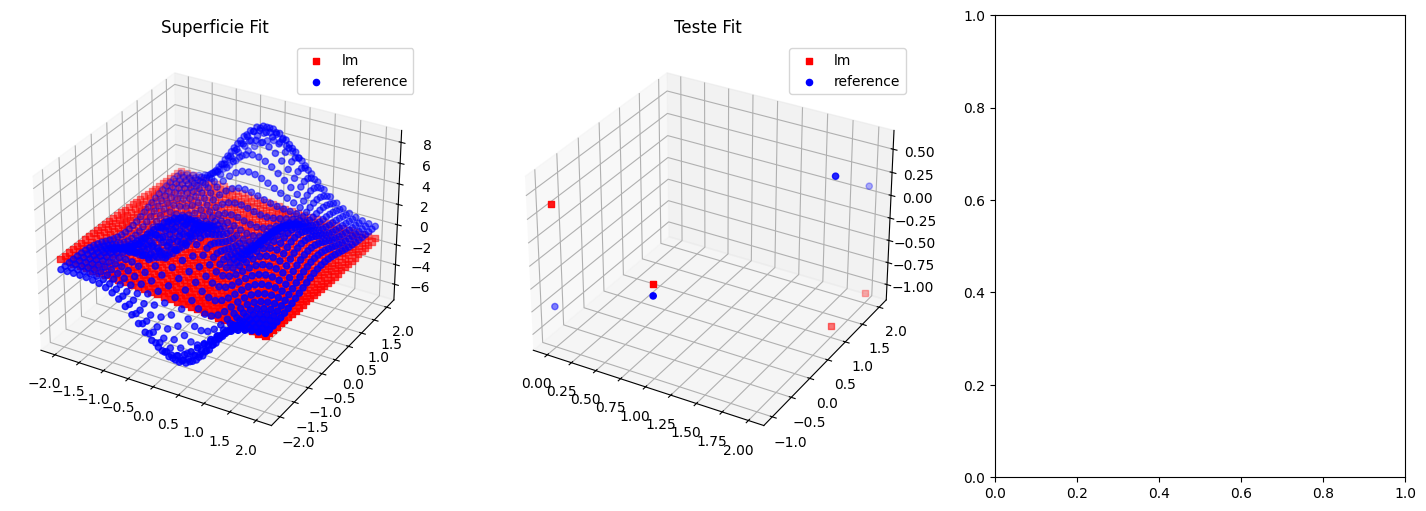

{'r2': -0.3506883452742573, 'r2_sup': -0.2747471116743898, 'r2_test': -0.39951214635716736, 'r2_val': -1.0253647958098648, 'r2_vt': -0.6439589888664867, 'mse': 5.66855, 'mse_sup': 8.52424, 'mse_test': 3.581142, 'mse_val': 3.7833185, 'mse_vt': 3.6822307}
1/1 [==============================] - 0s 35ms/step


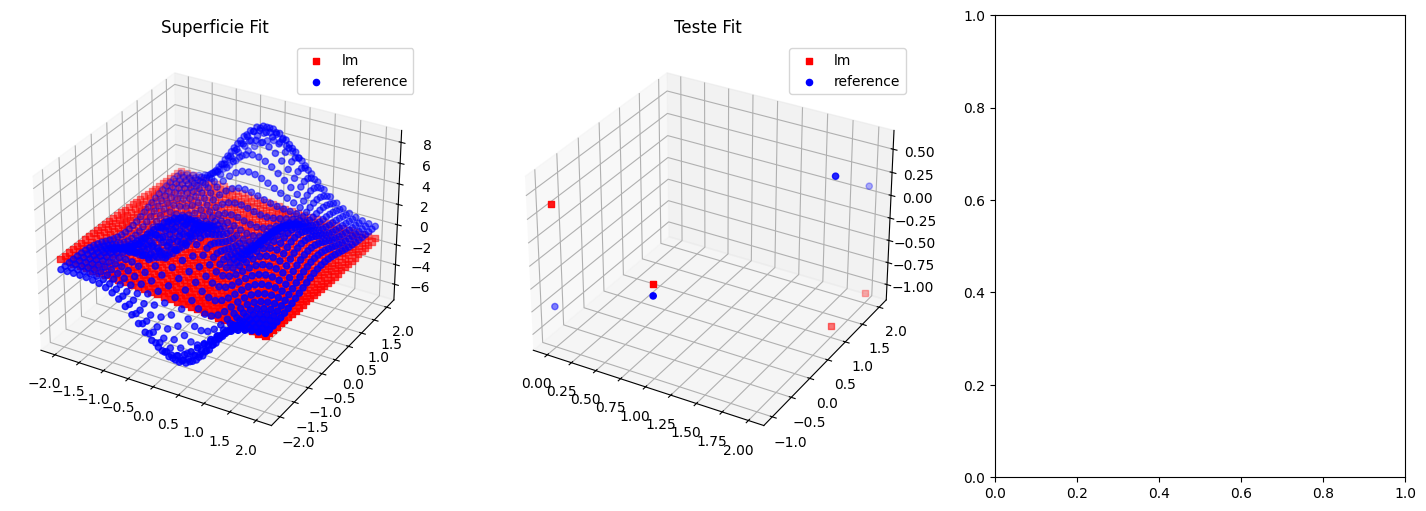

{'r2': -0.421608360552135, 'r2_sup': -0.31927365870454927, 'r2_test': -3.645794294532446, 'r2_val': -0.35776848194431476, 'r2_vt': -0.5295195515054099, 'mse': 5.966186, 'mse_sup': 8.821989, 'mse_test': 2.939282, 'mse_val': 3.0301483, 'mse_vt': 2.9847152}


In [108]:
tester.PlotBetterResults()